In [1]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import wandb
import scipy.interpolate as interp

api = wandb.Api()


In [2]:
run = api.run("/lucacorbucci/FL_fairness/runs/izamga23")


In [3]:
history = run.scan_history()


In [4]:
accuracy = [
    row["Test Accuracy"] for row in history if row["Test Accuracy"] is not None
][-1]
epsilon = [row["Train Epsilon"] for row in history if row["Train Epsilon"] is not None][
    -1
]
max_disparity = [
    row["Test Max Disparity"]
    for row in history
    if row["Test Max Disparity"] is not None
][-1]

In [10]:
# X = np.array(max_disparity)
# Y = np.array(epsilon)
# Z = np.array(accuracy)

# (
#     plotx,
#     ploty,
# ) = np.meshgrid(
#     np.linspace(np.min(X), np.max(X), 10), np.linspace(np.min(Y), np.max(Y), 10)
# )
# plotz = interp.griddata((X, Y), Z, (plotx, ploty), method="linear")


# fig = plt.figure(figsize=(12, 25))
# ax = fig.add_subplot(111, projection="3d")
# ax.set(xlabel=("Max Disparity"), ylabel=("Epsilon"), zlabel=("Accuracy"))
# ax.set_box_aspect(aspect=None, zoom=0.95)
# ax.plot_surface(plotx, ploty, plotz, cstride=1, rstride=1, cmap="viridis")  # or 'hot'

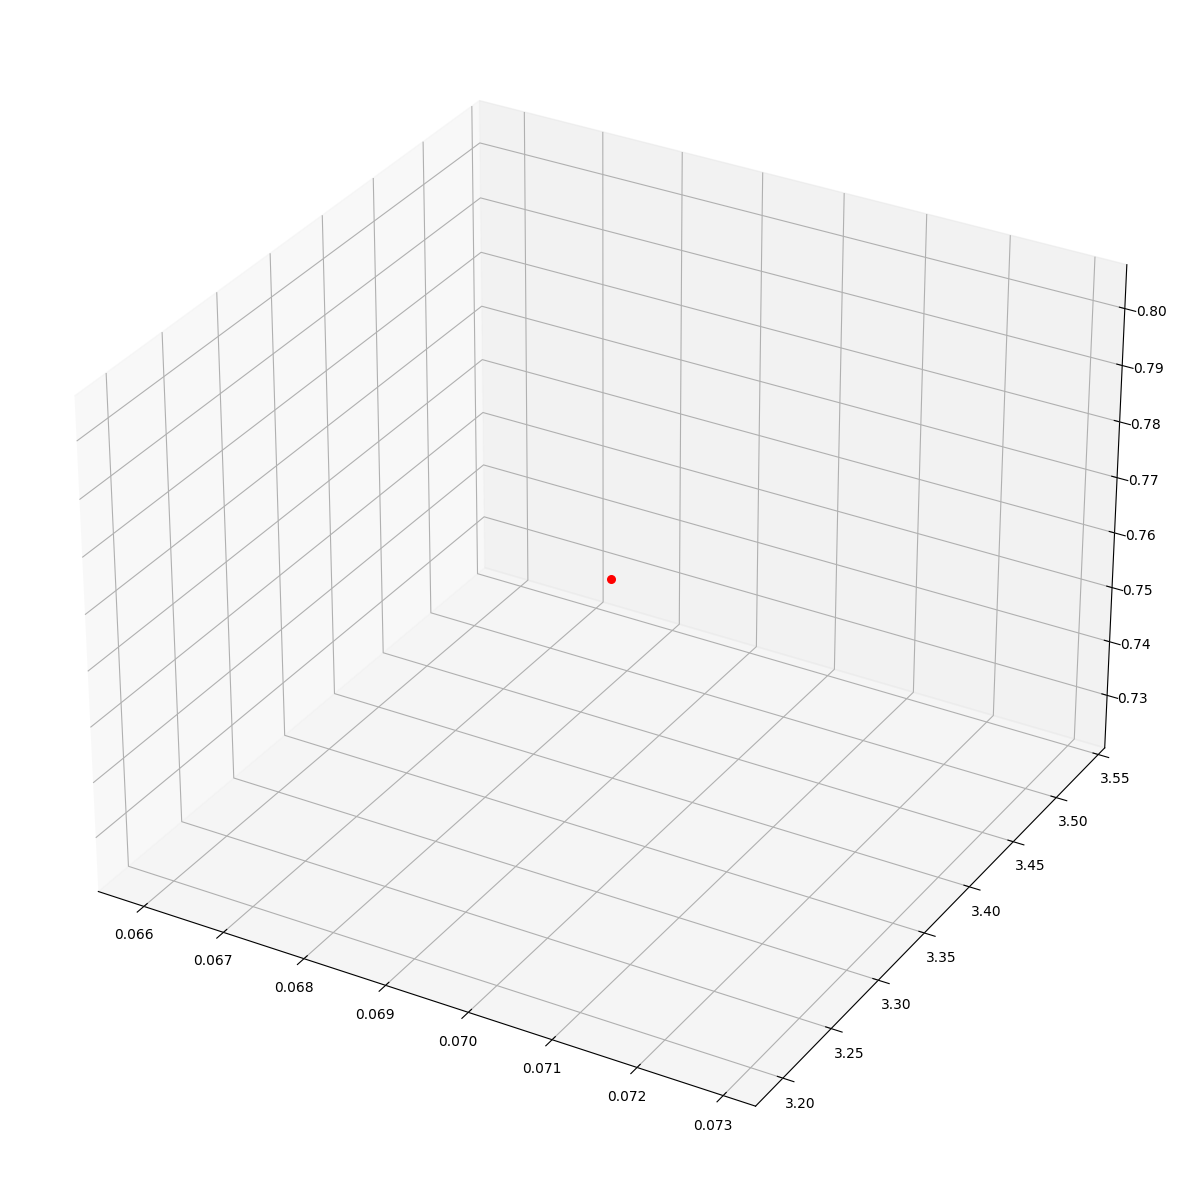

In [27]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [12, 12]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(max_disparity, epsilon, accuracy, c="red", s=30)

plt.show()